# RL for wind turbine control

## Imports

In [1]:
import gc
from datetime import datetime

from abc import abstractmethod, ABC
from math import sin, cos, radians
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm

from parameters import *

from implementations import *

## Parameters

In [2]:
checkpoint_filename = 'surrogate_model_phavg-full-2023.12.10_23.14.42.zip'  # set the best
case = 'full'  # set the same as the model
dataset_type = 'phavg'  # set the same as the model

## Load surrogate model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
case_array_dir = dataset_cases_dir[0] / 'array' / dataset_type

In [5]:
norm_infos = json.load(open(output_directory / f'dataset/{case}/array/{dataset_type}/norm.json'))

In [6]:
model = load_model(checkpoint_filename)
model.eval()

Sequential(
  (0): Linear(in_features=7, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=32, bias=True)
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=64, bias=True)
  (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=128, bias=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=256, bias=True)
  (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Linear(in_features=256, out_features=512, bias=True)
  (16): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17): ReLU()
  (18): Linear(in_f

## Environment

In [7]:
x_columns, y_columns

(('cos_phase', 'sin_phase', 'Ct', 'Cr', 'pitch', 'dpitch', 'action'),
 ('Ct', 'Cr'))

In [8]:
x_means_tensor = torch.tensor(norm_infos['X mean'], dtype=torch.float32).to(device)
x_stds_tensor = torch.tensor(norm_infos['X std'], dtype=torch.float32).to(device)
y_means_tensor = torch.tensor(norm_infos['Y mean'], dtype=torch.float32).to(device)
y_stds_tensor = torch.tensor(norm_infos['Y std'], dtype=torch.float32).to(device)


def encode_state(phase: float, pitch: float, dpitch: float, c_t: float, c_r: float) -> torch.tensor:
    """
    Encodes the state into a tensor
    :param phase: phase of the wind turbine
    :param pitch: pitch angle of the blade
    :param dpitch: pitch angle variation of the blade
    :param c_t: tangential force on the blade
    :param c_r: radial force on the blade
    :return: encoded state
    """
    cos_phase = cos(radians(phase))
    sin_phase = sin(radians(phase))
    x = torch.tensor([cos_phase, sin_phase, c_t, c_r, pitch, dpitch], dtype=torch.float32).to(device)
    return x


def normalize_states(x: torch.tensor) -> torch.tensor:
    """
    Normalizes the states
    :param x: states to normalize, shape (len(x_columns) - 1, pool_size)
    :return: normalized states, shape (len(x_columns) - 1, pool_size)
    """
    x = (x - x_means_tensor[:-1].reshape(-1, 1)) / x_stds_tensor[:-1].reshape(-1, 1)
    return x.detach()


def encode_action(action: float) -> torch.tensor:
    """
    Encodes the action into a tensor (normalized)
    :param action: action to encode
    :return: encoded action
    """
    return torch.tensor([action]).to(device)


def normalize_actions(actions: torch.tensor) -> torch.tensor:
    """
    Normalizes the actions
    :param actions: actions to normalize, shape (pool_size, )
    :return: normalized actions, shape (pool_size, )
    """
    actions = (actions - x_means_tensor[-1]) / x_stds_tensor[-1]
    return actions.detach()


def merge_states_actions(states: torch.tensor, actions: torch.tensor) -> torch.tensor:
    """
    Merges the states and the actions into a tensor
    :param states: states to merge, shape (len(x_columns) - 1, pool_size)
    :param actions: actions to merge, shape (pool_size,)
    :return: merged states and actions, shape (len(x_columns), pool_size)
    """
    actions = actions.unsqueeze(0)
    result = torch.cat((states, actions.view(1, -1)), dim=0)
    del actions
    torch.cuda.empty_cache()
    return result.detach()


def denormalize_states(x: torch.tensor) -> torch.tensor:
    """
    Denormalizes the states
    :param x: states to denormalize, shape (len(x_columns) - 1, pool_size)
    :return: denormalized states, shape (len(x_columns) - 1, pool_size)
    """
    x = x * x_stds_tensor[:-1].reshape(-1, 1) + x_means_tensor[:-1].reshape(-1, 1)
    return x.detach()


def denormalize_prediction(y: torch.tensor) -> torch.tensor:
    """
    Denormalizes the prediction
    :param y: prediction to denormalize, shape (len(y_columns), pool_size)
    :return: denormalized prediction, shape (len(y_columns), pool_size)
    """
    y = y * y_stds_tensor + y_means_tensor
    return y.detach()


def denormalize_actions(actions: torch.tensor) -> torch.tensor:
    """
    Denormalizes the actions
    :param actions: actions to denormalize, shape (pool_size, )
    :return: denormalized actions, shape (pool_size, )
    """
    actions = actions.view(-1) * x_stds_tensor[-1] + x_means_tensor[-1]
    return actions.detach()


def split_states_actions(x: torch.tensor) -> (torch.tensor, torch.tensor):
    """
    Splits the states and the actions
    :param x: states and actions to split, shape (len(x_columns) + 1, pool_size)
    :return: states, shape (len(x_columns), pool_size), actions, shape (pool_size, )
    """
    return x[:-1, :].detach(), x[-1, :].detach()


In [9]:
def simulate_step(states: torch.tensor, actions: torch.tensor) -> (torch.tensor, torch.tensor):
    """
    Simulates one step of the environment
    :param states: states of the environment, shape (len(x_columns) - 1, pool_size) NOT NORMALIZED
    :param actions: actions to take, shape (pool_size, ) NOT NORMALIZED
    :return: new states, shape (len(x_columns) - 1, pool_size), rewards, shape (pool_size, )
    """
    with torch.no_grad():
        # normalize states and actions
        x = normalize_states(states).detach()
        # merge states and actions
        x = merge_states_actions(x, normalize_actions(actions))
        # predict Ct and Cr
        y = model(x.T).to(device)
        # denormalize y
        y = denormalize_prediction(y)
        ct, cr = y[:, y_columns.index('Ct')], y[:, y_columns.index('Cr')]

        # replace in x
        states[x_columns.index('Ct')] = ct
        states[x_columns.index('Cr')] = cr

        # compute new phase
        phase = torch.arctan2(states[x_columns.index('sin_phase')], states[x_columns.index('cos_phase')]) + \
                rad_per_step
        # replace in x
        states[x_columns.index('sin_phase')] = torch.sin(phase)
        states[x_columns.index('cos_phase')] = torch.cos(phase)
        # compute new pitch
        pitch = states[x_columns.index('pitch')] + actions
        pitch = torch.clamp(pitch, *pitch_bounds)
        # replace in x
        states[x_columns.index('pitch')] = pitch
        # put action in dpitch place
        states[x_columns.index('dpitch')] = actions
        # compute cp = radius * omega * ct and thrust forces
        rewards = rad_per_step * ct

        # free memory
        del x, y, ct, cr, phase, pitch
        torch.cuda.empty_cache()  # Explicitly release GPU memory

        return states, rewards.reshape(-1)

In [10]:
def simulate_open_loop_episodes(initial_states: torch.tensor, actions: torch.tensor) -> (torch.tensor, torch.tensor):
    """
    Simulates pool_size open loop episodes of the environment in parallel
    :param initial_states: initial states of the environment, shape (len(x_columns) - 1, pool_size)
    :param actions: actions to take (len(actions), pool_size)
    :return: states (len(x_columns), len(actions), pool_size), rewards (len(actions), pool_size)
    """
    # initialize states and rewards
    state_size, pool_size = initial_states.shape
    steps = actions.shape[0]
    states = torch.zeros((state_size, steps, pool_size), dtype=torch.float32).to(device)
    rewards = torch.zeros((steps, pool_size), dtype=torch.float32).to(device)
    # simulate steps
    curr_state = initial_states.clone()
    for i, act in enumerate(actions):
        actions[i, :] = act
        states[:, i, :], rewards[i, :] = simulate_step(curr_state, actions[i, :])
        curr_state = states[:, i, :].clone().detach()
    return states, rewards

In [11]:
def plot_compare_episodes(pred_states: torch.tensor,
                          pred_actions: torch.tensor,
                          true_states: torch.tensor,
                          true_actions: torch.tensor,
                          n: int = int(1e9)):
    # vertically : [pred, true, pred and true (on same plot), pred - true]
    # horizontally : [alpha, gamma, c_t, c_thrust, c_m, reward, action]

    def plot_feature(pred_feature, true_feature):
        pred_feature = pred_feature[:n].detach().to('cpu').numpy().reshape(-1)
        true_feature = true_feature[:n].detach().to('cpu').numpy().reshape(-1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].set_title('pred')
        axs[0].plot(pred_feature)
        axs[1].set_title('true')
        axs[1].plot(true_feature)
        axs[2].set_title('pred and true')
        axs[2].plot(pred_feature, label='pred')
        axs[2].plot(true_feature, label='true')
        axs[2].legend()
        axs[3].set_title('pred - true')
        axs[3].plot(np.array(pred_feature) - np.array(true_feature))
        return fig

    # plot actions
    fig = plot_feature(pred_actions, true_actions)
    fig.suptitle('action')
    plt.show()
    # plot features
    for i, feature in enumerate(x_columns[:-1]):
        fig = plot_feature(pred_states[i], true_states[i])
        fig.suptitle(feature)
        plt.show()

## Load true episode

In [12]:
df = pd.read_pickle(f'outputs/dataset/case 1/dataframes/{dataset_type}/ms008mpt196.pkl')
df

,Cm,Cmx,Cmy,Cp,Cr,Ct,Cthrust,Ctot,Fr,Ft,...,dMz,phase,pitch,pitch_max,pitch_min,pitch_std,t,t_T,tc,tc_Ueff
0,-0.249436,0.059849,0.233163,-0.062574,3.201710,-0.044932,0.079381,3.202325,10.051502,-0.141062,...,0.004402,0.600000,-0.021186,-0.016153,-0.026137,0.002778,0.000000,0.000000,0.000000,0.000000
1,-0.020035,0.211658,0.127211,-0.100742,2.923283,-0.147298,0.548694,2.927582,9.177407,-0.462431,...,0.006080,7.922449,0.020164,0.021809,0.018387,0.000972,0.023028,0.020408,0.320571,0.533735
2,-0.026720,0.291097,0.008748,-0.062830,2.665650,-0.091316,0.788941,2.667537,8.368588,-0.286678,...,0.002992,15.244898,0.019720,0.021419,0.017884,0.000985,0.046056,0.040816,0.641141,1.065032
3,0.185711,0.204509,0.180871,0.162169,2.546062,0.271058,0.726659,2.561052,7.993151,0.850964,...,0.003221,22.567347,-0.018011,-0.013552,-0.022452,0.002482,0.069084,0.061224,0.961712,1.591813
4,0.064821,0.105172,0.209577,0.331277,2.499020,0.505031,0.806918,2.549813,7.845466,1.585502,...,0.003940,29.889796,-0.081525,-0.075732,-0.087272,0.003308,0.092112,0.081633,1.282283,2.112021
5,0.072829,0.232697,0.151523,0.244146,1.942440,0.377083,0.873786,1.979123,6.098131,1.183821,...,0.002496,37.212244,-0.151972,-0.146504,-0.157402,0.003192,0.115140,0.102041,1.602853,2.623628
6,-0.034284,0.288528,0.078821,0.258223,1.886026,0.387490,1.046603,1.925914,5.921021,1.216493,...,0.002722,44.534694,-0.210193,-0.206317,-0.213948,0.002188,0.138168,0.122449,1.923424,3.124647
7,-0.105420,0.232110,0.137190,0.458668,2.267437,0.683434,1.360982,2.368547,7.118432,2.145583,...,0.004598,51.857143,-0.240394,-0.239226,-0.241364,0.000591,0.161196,0.142857,2.243995,3.613142
8,-0.308755,0.299567,0.159465,0.581917,2.922119,0.885315,2.055687,3.053710,9.173753,2.779373,...,0.003557,59.179593,-0.234347,-0.232275,-0.236237,0.001134,0.184224,0.163265,2.564565,4.087233
9,-0.275943,0.367008,0.122764,0.546177,3.583232,0.855817,2.944238,3.684244,11.249261,2.686766,...,0.002159,66.502040,-0.194568,-0.190176,-0.198995,0.002571,0.207252,0.183673,2.885136,4.545112


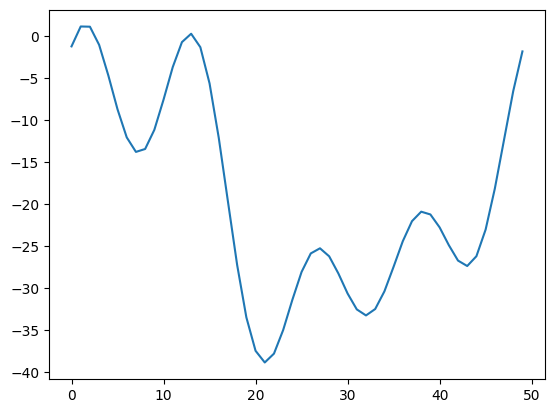

In [13]:
plt.plot(np.rad2deg(df['pitch']))

In [14]:
deg_per_step = df['phase'].iloc[1] - df['phase'].iloc[0]
rad_per_step = np.deg2rad(deg_per_step)
deg_per_step

7.3224491270221

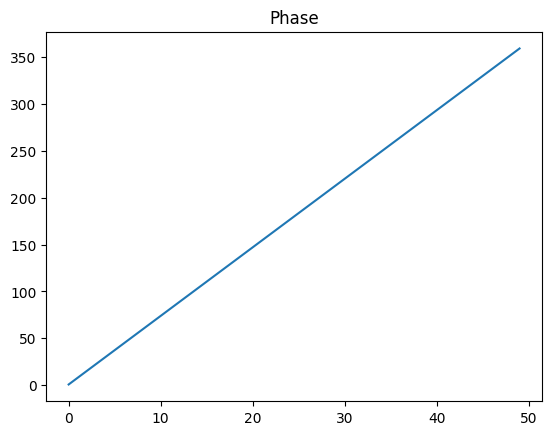

In [15]:
plt.plot(df['phase'])
plt.title('Phase')
plt.show()

In [16]:
pitches = np.array(df['pitch'])
actions = torch.tensor(pitches[1:] - pitches[:-1], dtype=torch.float32).to(device).reshape(-1, 1)
X0 = df.iloc[0]
X1 = df.iloc[1]
initial_states = encode_state(
    phase=X1['phase'],
    pitch=X1['pitch'],
    dpitch=X1['pitch'] - X0['pitch'],
    c_t=X1['Ct'],
    c_r=X1['Cr'],
).reshape(-1, 1)

## Simulate and compare to true episode

In [17]:
pred_states, pred_rewards = simulate_open_loop_episodes(initial_states, actions)
pred_rewards = pred_rewards.reshape(-1)[1:]

In [18]:


true_rewards = torch.tensor(np.array(df['Cp'][1:]), dtype=torch.float32).to(device).reshape(-1)
true_states = pd.DataFrame({
    'cos_phase': np.cos(np.deg2rad(df['phase'][1:])),
    'sin_phase': np.sin(np.deg2rad(df['phase'][1:])),
    'c_t': np.array(df['Ct'][1:]),
    'c_r': np.array(df['Cr'][1:]),
    'pitch': np.array(df['pitch'][1:]),
    'dpitch': np.array(df['pitch'][1:]) - np.array(df['pitch'][:-1]),
})
true_states = torch.tensor(list(map(np.array, [
    true_states['cos_phase'],
    true_states['sin_phase'],
    true_states['c_t'],
    true_states['c_r'],
    true_states['pitch'],
    true_states['dpitch'],
])), dtype=torch.float32).to(device)

C:\Users\Romain\AppData\Local\Temp\ipykernel_11952\2345393687.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  true_states = torch.tensor(list(map(np.array, [


In [19]:
print(pred_states.shape, true_states.shape)
print(pred_rewards.shape, true_rewards.shape)
print(actions.shape)

torch.Size([6, 49, 1]) torch.Size([6, 49])
torch.Size([48]) torch.Size([49])
torch.Size([49, 1])


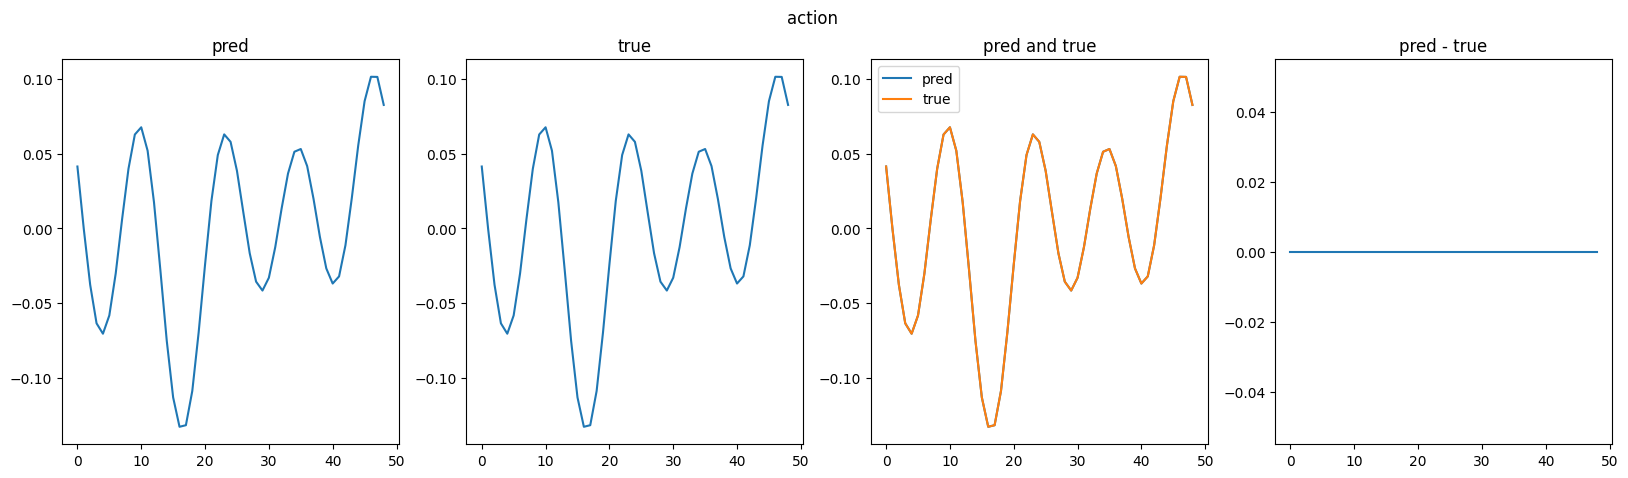

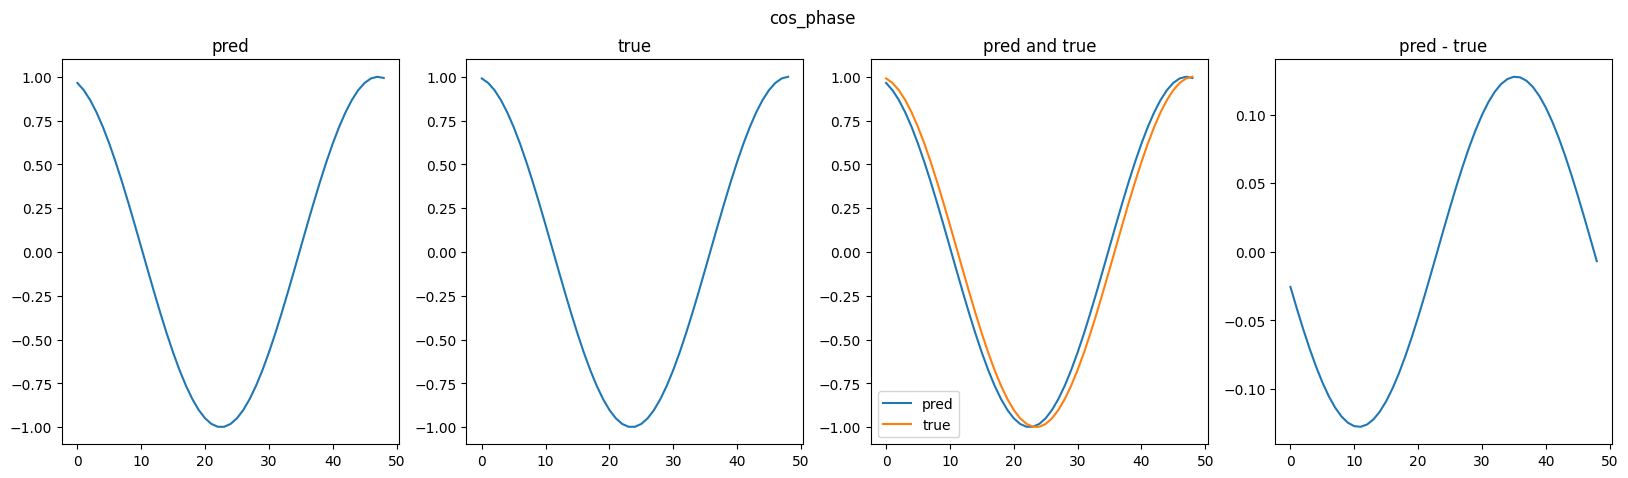

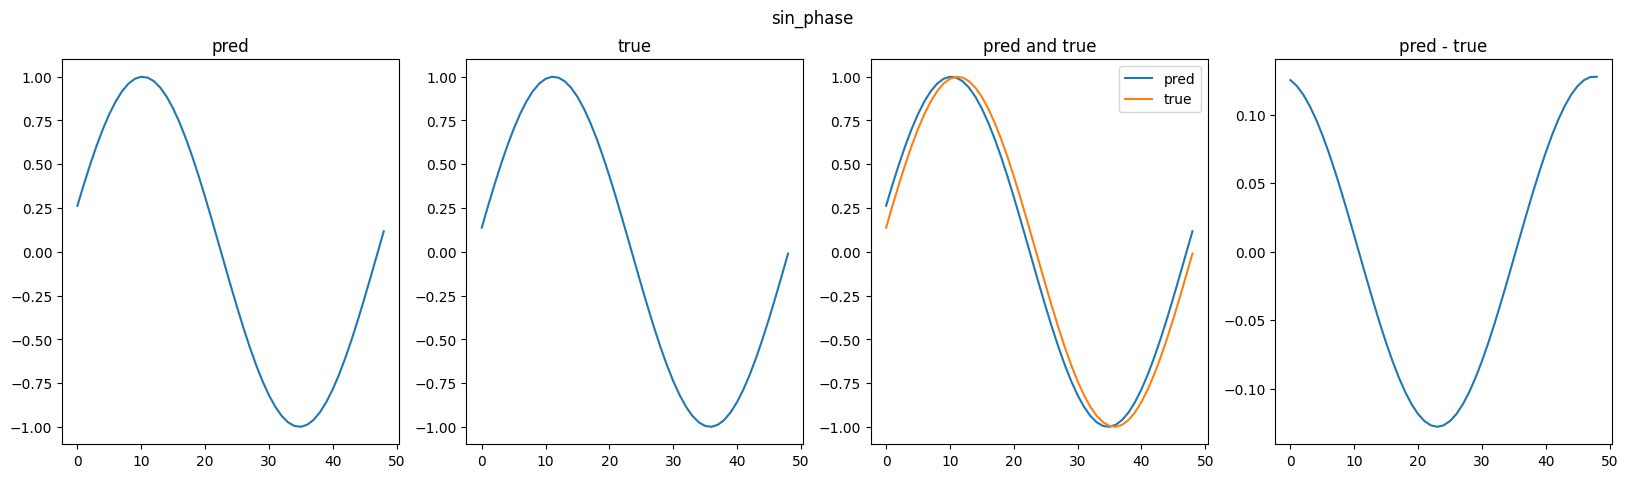

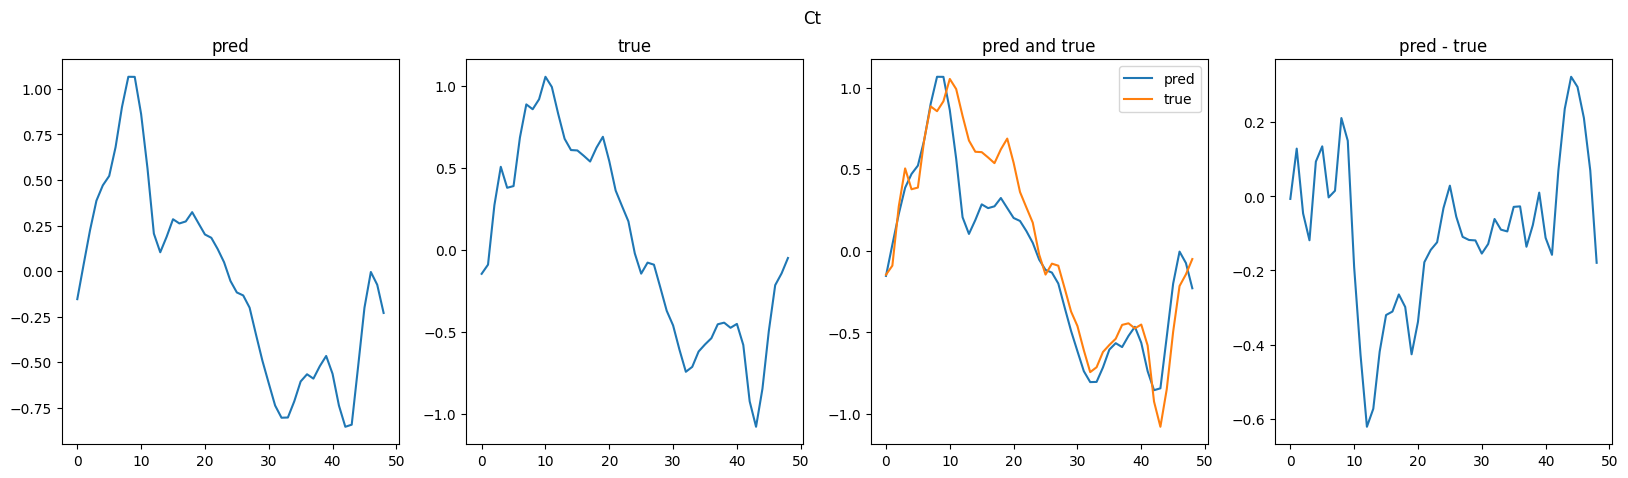

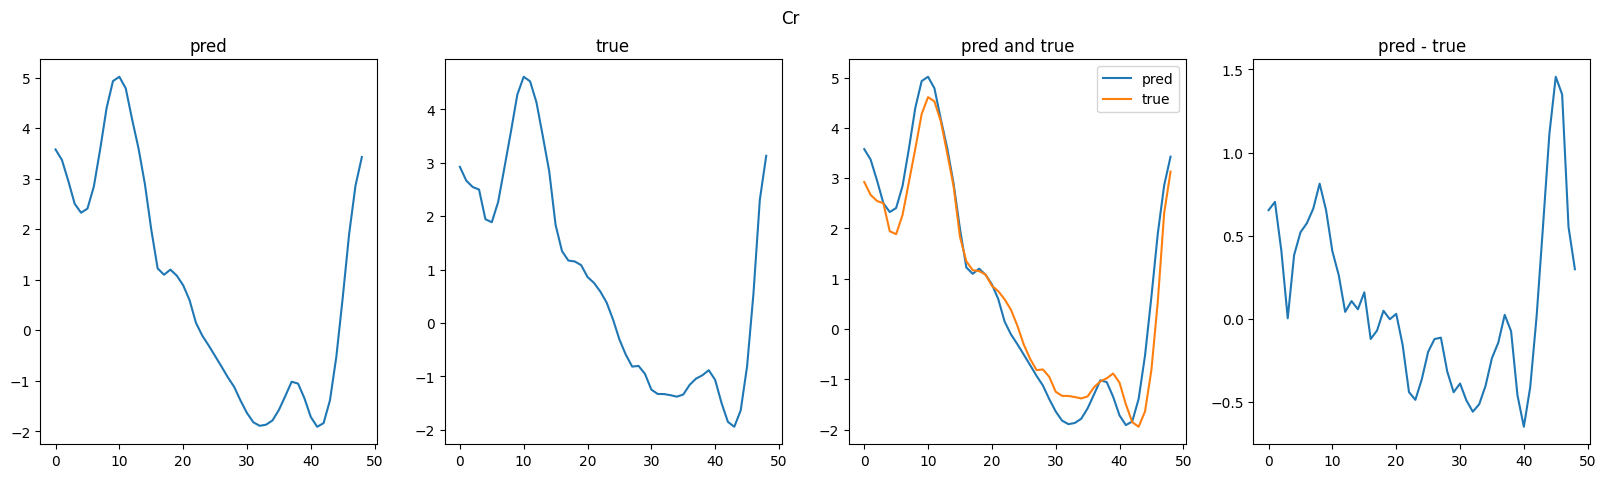

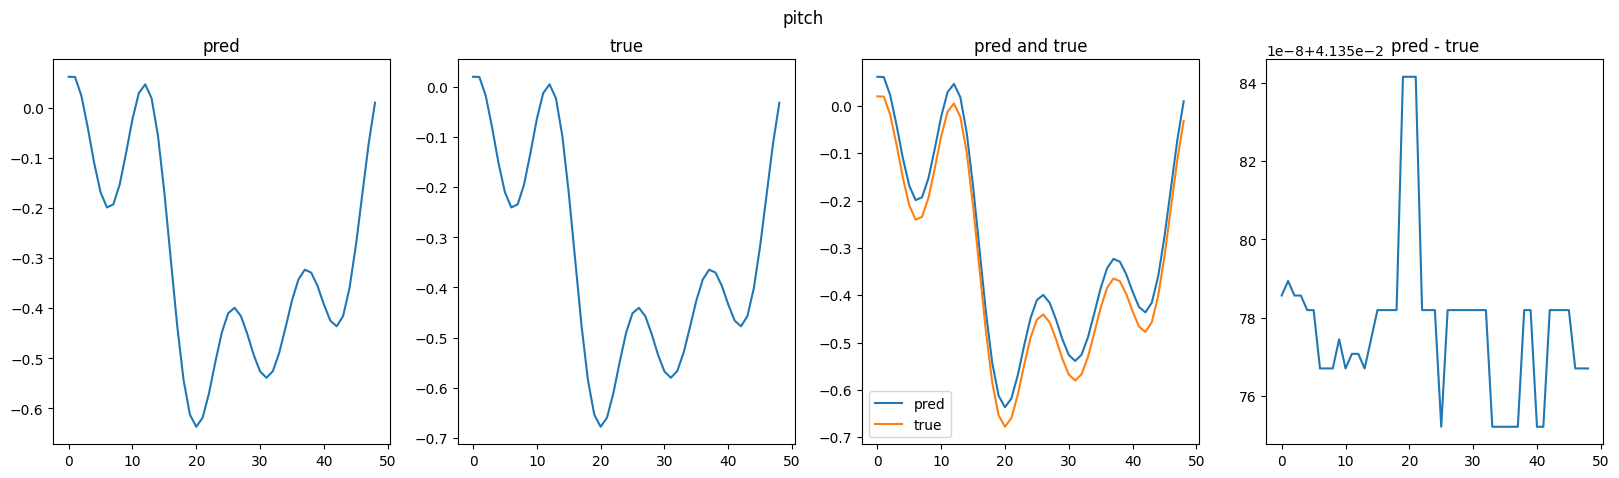

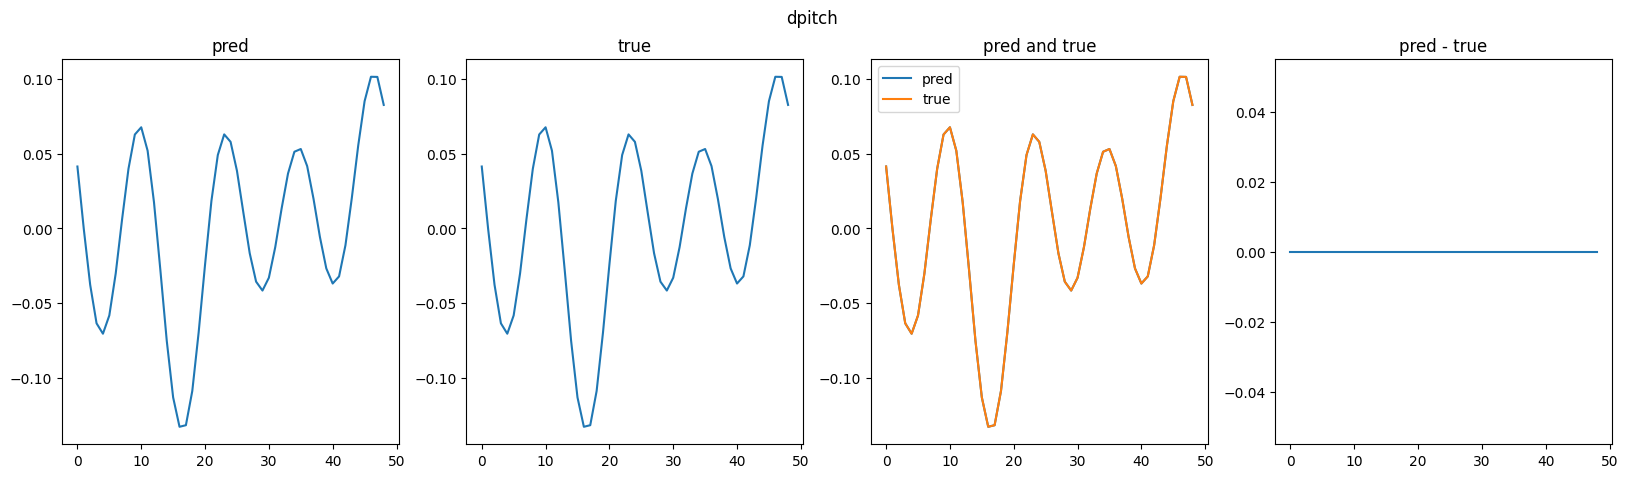

In [20]:
plot_compare_episodes(pred_states=pred_states,
                      pred_actions=actions,
                      true_states=true_states,
                      true_actions=actions,
                      n=49)

## Agent

In [21]:
class Agent(ABC):
    @abstractmethod
    def __call__(self, states: torch.tensor, rewards: torch.tensor, done: bool) -> torch.tensor:
        """
        Takes pool_size actions in parallel
        :param states: current states of the environment, shape (len(x_columns) - 1, pool_size)
        :param rewards: observed rewards, shape (pool_size, )
        :param done: whether the episode is done
        :return: actions to take, shape (pool_size, )
        """
        pass


class NoAgent(Agent):
    def __call__(self, states: torch.tensor, rewards: torch.tensor, done: bool) -> torch.tensor:
        __doc__ = super().__call__.__doc__
        return torch.zeros(states.shape[1], dtype=torch.float32).to(device)

In [22]:
def simulate_closed_loop_episodes(initial_states: torch.tensor, agent: Agent, steps: int) -> \
        (torch.tensor, torch.tensor, torch.tensor):
    """
    Simulates pool_size episodes of the environment with the given agent in parallel
    :param state: initial states of the environment, shape (len(x_columns) - 1, pool_size)
    :param agent: agent to act
    :param steps: number of steps to simulate
    :return:
        - states (len(x_columns), steps, pool_size)
        - actions (steps, pool_size)
        - rewards (steps, pool_size)
    """
    state_size, pool_size = initial_states.shape
    states = torch.zeros((state_size, steps + 1, pool_size), dtype=torch.float32).to(device)
    actions = torch.zeros((steps, pool_size), dtype=torch.float32).to(device)
    rewards = torch.zeros((steps, pool_size), dtype=torch.float32).to(device)
    # set initial states
    states[:, 0, :] = initial_states.clone()
    # simulate steps
    for i in range(steps):
        act = agent(states[:, i, :], rewards[i, :], i == steps - 1)
        actions[i, :] = act
        states[:, i + 1, :], rewards[i, :] = simulate_step(states[:, i, :], actions[i, :])
    return states, actions, rewards

In [23]:
pred_states, pred_actions, pred_rewards = simulate_closed_loop_episodes(initial_states, NoAgent(), turn_length)

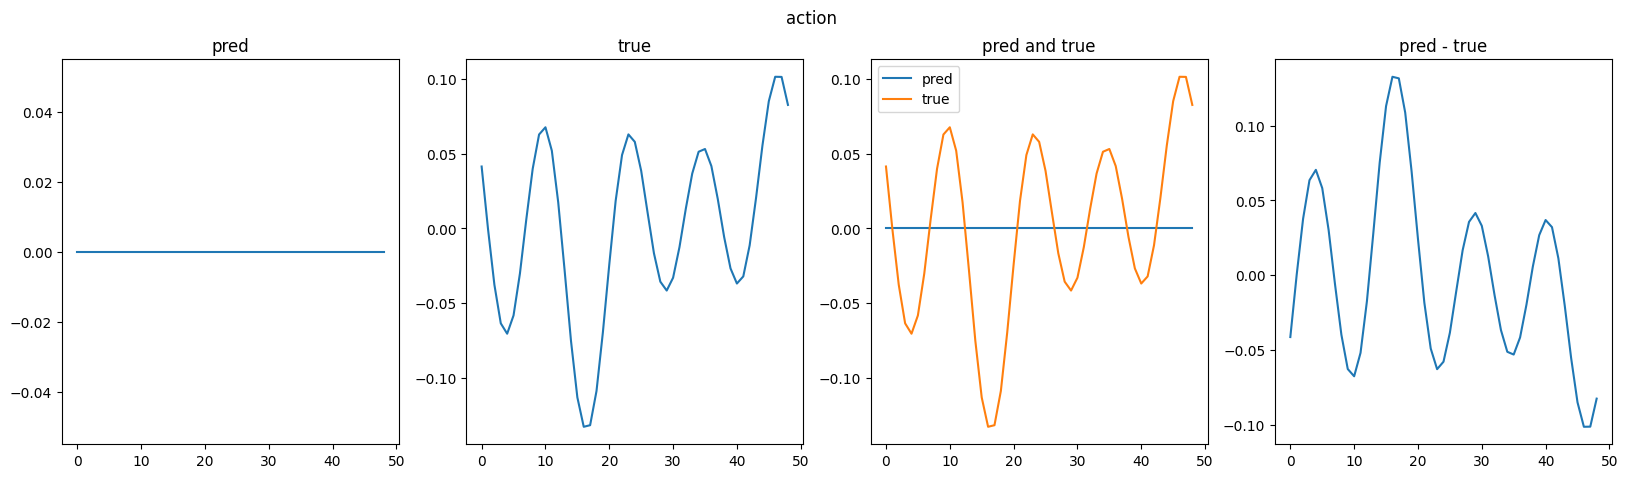

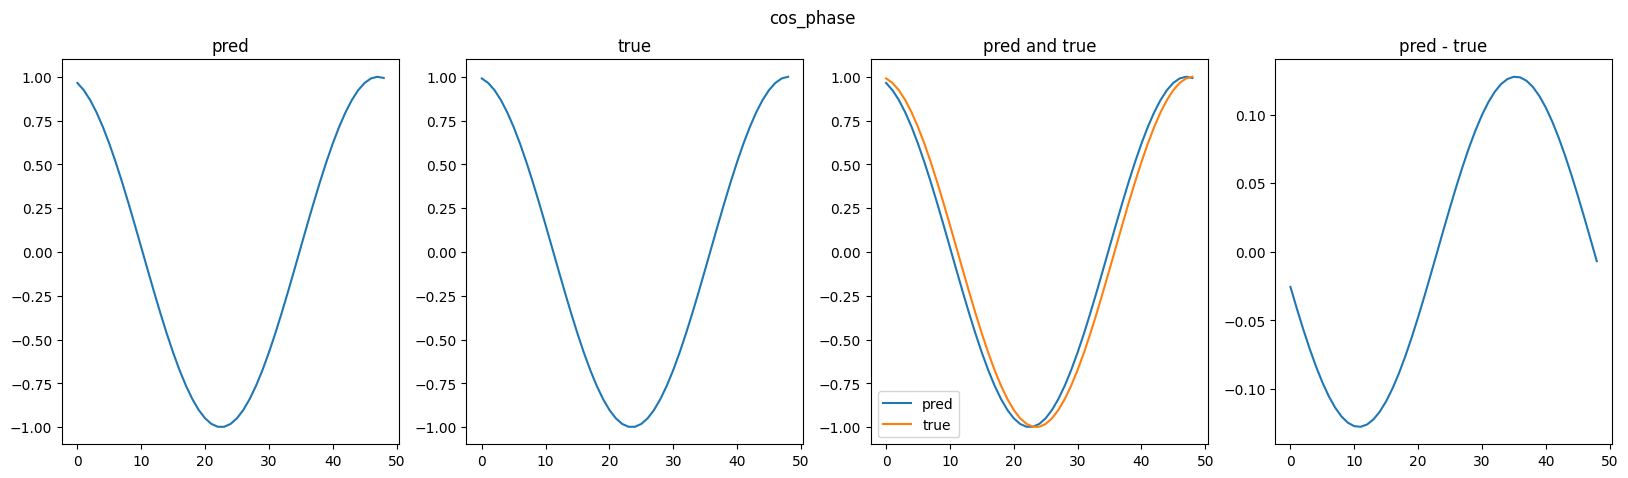

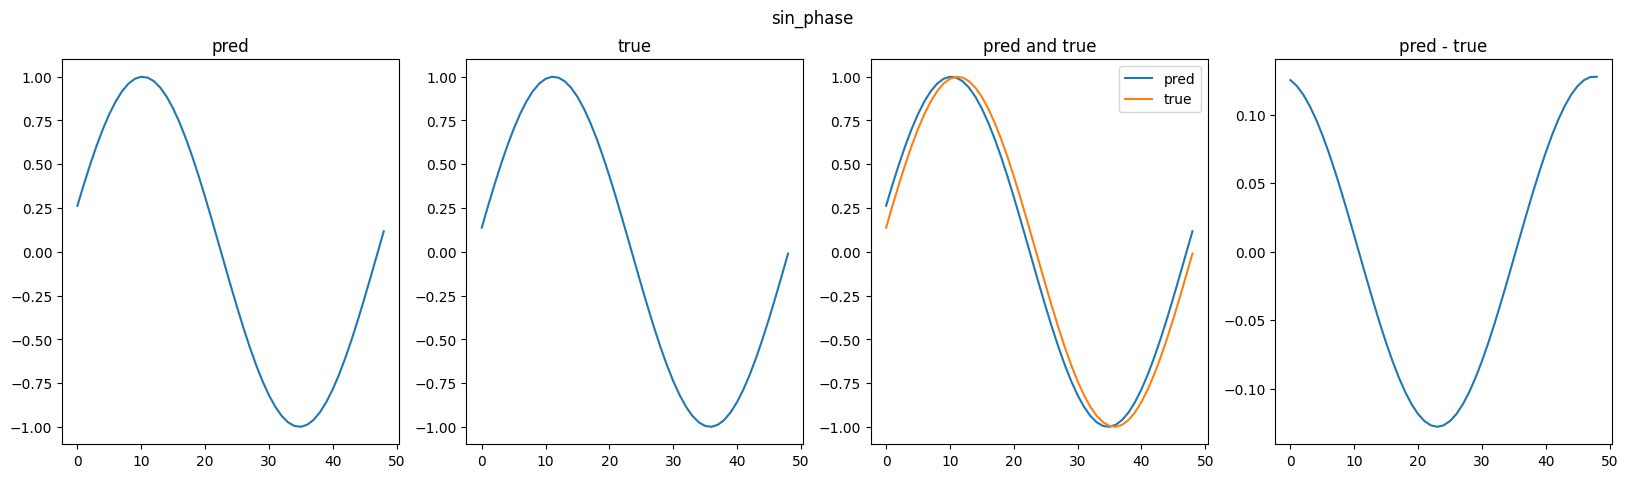

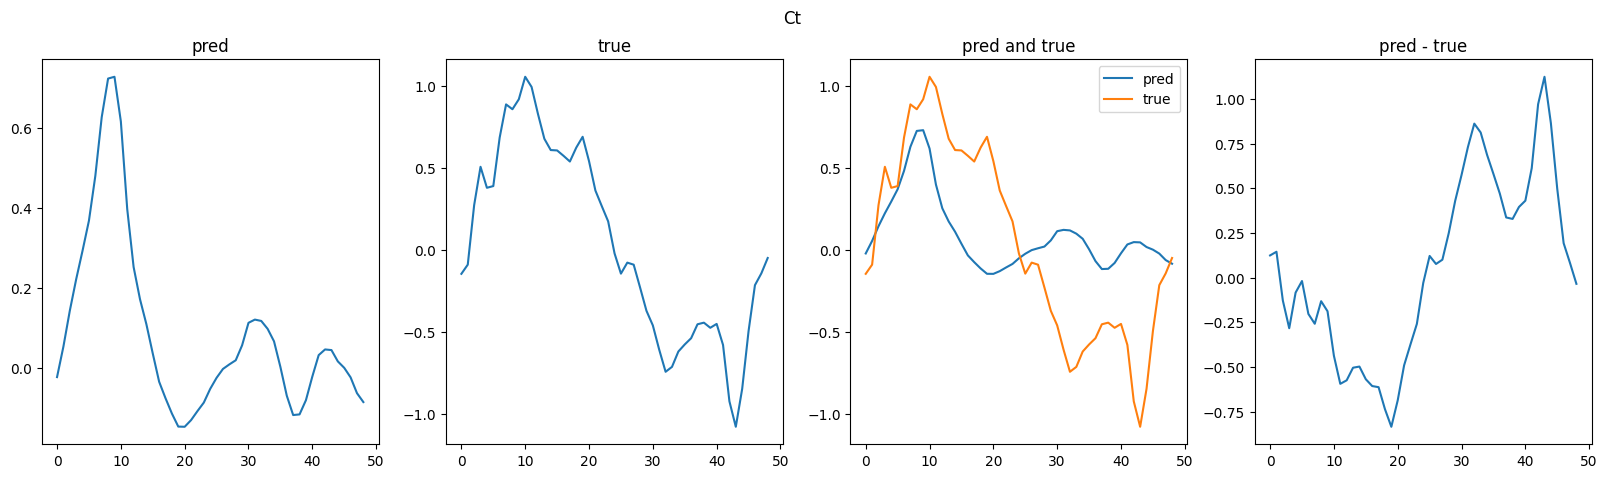

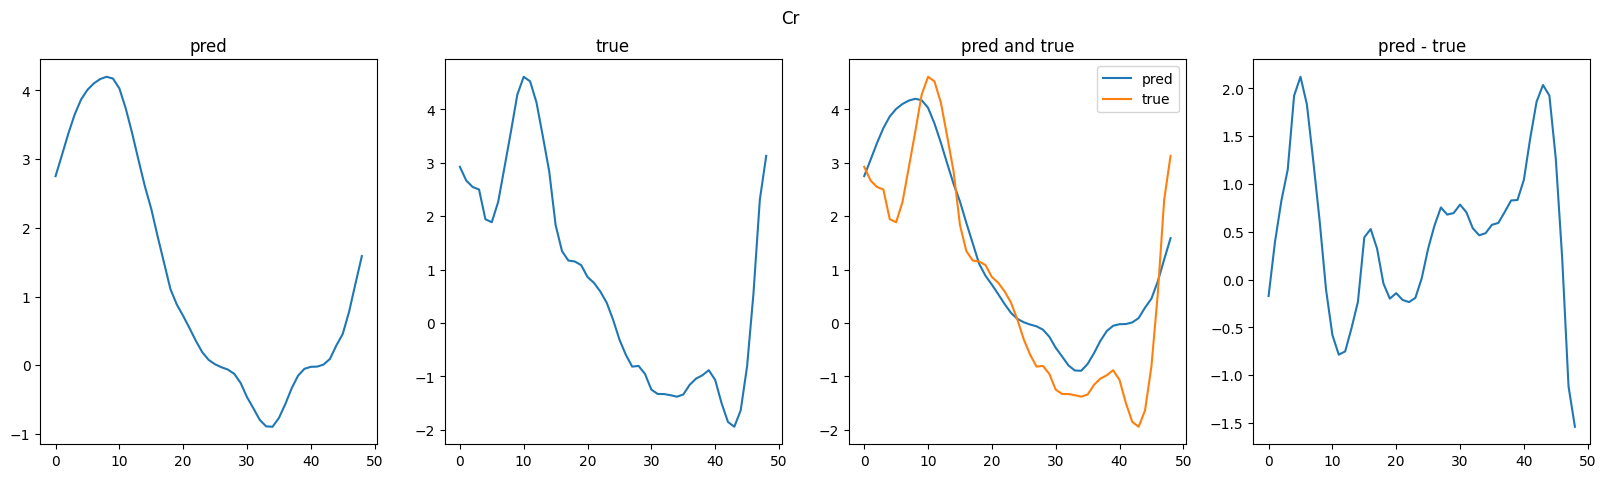

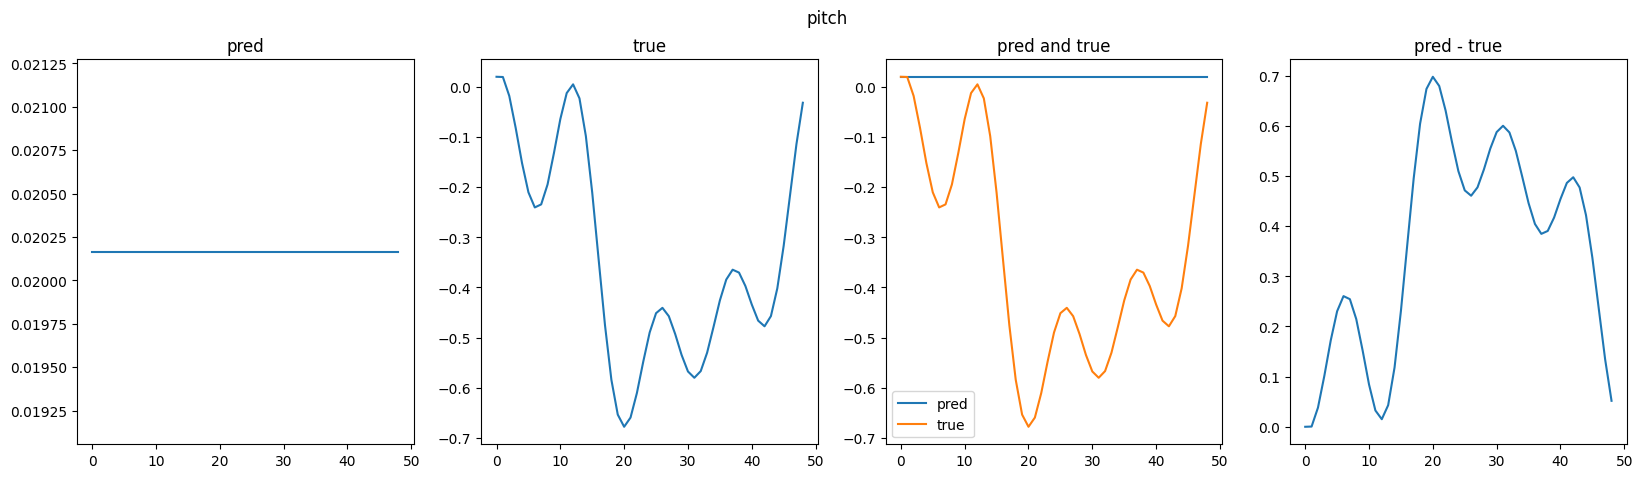

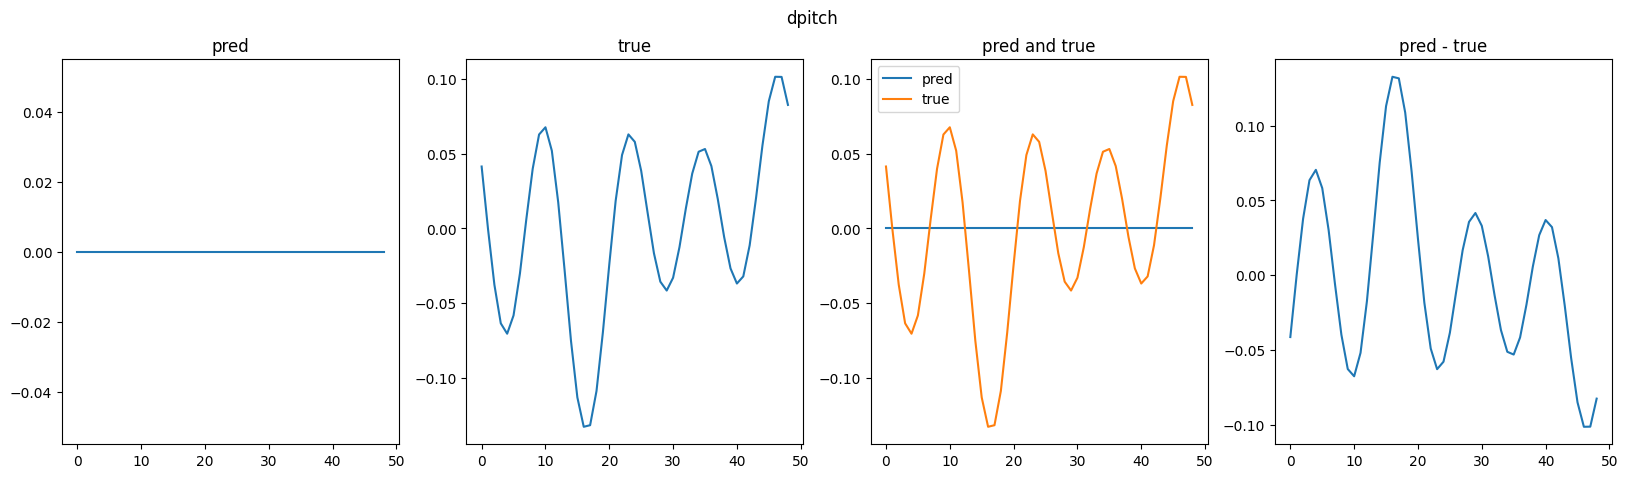

In [24]:
plot_compare_episodes(pred_states, pred_actions, true_states, actions, n=49)

## DDPG agent
![DDPG Algorithm](https://i.imgur.com/mS6iGyJ.jpg)

In [25]:
X = np.load(f'outputs/dataset/{case}/array/{dataset_type}/X.npy')

actions = X[:, -1]
min_action, max_action = min(actions).item(), max(actions).item()
min_action, max_action

(-4.44609388928192, 4.0010370929369925)

In [26]:
class DDPGAgent(Agent):
    def __init__(self):
        # randomly initialize critic network Q(s,a|theta_Q) and actor mu(s|theta_mu) with weights theta_Q and theta_mu
        self.critic = create_mlp(widths=ddpg_critic_model_layer_widths).to(device)
        self.actor = create_mlp(widths=ddpg_actor_model_layer_widths).to(device)
        # initialize target network Q' and mu' with weights theta_Q' = theta_Q and theta_mu' = theta_mu
        self.critic_target = create_mlp(widths=ddpg_critic_model_layer_widths).to(device)
        self.actor_target = create_mlp(widths=ddpg_actor_model_layer_widths).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.actor_target.load_state_dict(self.actor.state_dict())
        # initialize replay buffer R (state_t, action_t, reward_t, state_t+1, done_t+1)
        self.replay_buffer_state_t = torch.zeros((ddpg_replay_buffer_size, len(x_columns) - 1), dtype=torch.float32).to(
            device)
        self.replay_buffer_action_t = torch.zeros((ddpg_replay_buffer_size, 1), dtype=torch.float32).to(device)
        self.replay_buffer_reward_t = torch.zeros((ddpg_replay_buffer_size, 1), dtype=torch.float32).to(device)
        self.replay_buffer_state_t1 = torch.zeros((ddpg_replay_buffer_size, len(x_columns) - 1),
                                                  dtype=torch.float32).to(device)
        self.replay_buffer_done_t1 = torch.zeros((ddpg_replay_buffer_size, 1), dtype=torch.float32).to(device)
        self.replay_buffer_counter = 0

        # temporary variables s_{t-1}, a_{t-1}
        self.last_states, self.last_actions = None, None

        # learning variables
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=ddpg_critic_learning_rate)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=ddpg_actor_learning_rate)

        # train mode by default
        self.__eval_mode = False

        self.counter = 0

    def eval(self):
        self.__eval_mode = True
        self.actor.eval()
        self.critic.eval()
        self.actor_target.eval()
        self.critic_target.eval()

    def train(self):
        self.__eval_mode = False
        self.actor.train()
        self.critic.train()
        self.actor_target.train()
        self.critic_target.train()

    def reset(self):
        """
        Resets the agent (e.g. at the end of an episode)
        :return:
        """
        self.counter = 0
        self.last_state_actor, self.last_state_surrogate = None, None

    def __call__(self, states: torch.tensor, rewards: torch.tensor, done: bool) -> torch.tensor:
        __doc__ = super().__call__.__doc__

        # normalize states
        states = normalize_states(states)
        states = states.T.detach()  # switch from (len(x_columns) - 1, pool_size) to (pool_size, len(x_columns) - 1)
        rewards = rewards.detach()
        done = torch.tensor(done, dtype=torch.float32).to(device)
        self.counter += 1
        self.actor.eval()

        # select action a_t = mu(s_t|theta_mu) + N_t according to the current policy and exploration noise
        actions = self.actor(states).detach()

        # denormalize actions
        actions = actions.detach().squeeze(1)

        # add exploration noise
        if not self.__eval_mode:
            actions += torch.Tensor(np.random.normal(0, ddpg_exploration_noise, 1)).to(device)

        actions = clip_action(actions, min_action, max_action)

        # store transition (s_{t-1}, a_{t-1}, r_{t-1}, s_t, done_t) in R
        if not self.__eval_mode:
            if self.last_states is not None:
                # unpack all episodes in parallel into the replay buffer
                pool_size = states.shape[0]
                # Calculate the indices to update in the replay buffer
                indices = torch.arange(self.replay_buffer_counter,
                                       self.replay_buffer_counter + pool_size) % ddpg_replay_buffer_size
                # Update the replay buffer with new episodes
                self.replay_buffer_state_t[indices, :] = self.last_states
                self.replay_buffer_action_t[indices, :] = self.last_actions.reshape(-1, 1)
                self.replay_buffer_reward_t[indices, :] = rewards.reshape(-1, 1)
                self.replay_buffer_state_t1[indices, :] = states
                self.replay_buffer_done_t1[indices, :] = done.reshape(-1, 1)

                # Increment replay buffer counter
                self.replay_buffer_counter += pool_size

            # make a training step
            self.actor.train()
            self.critic.train()
            self.train_step()
            self.actor.eval()
            self.critic.eval()

            self.last_states, self.last_actions = states, actions

        return denormalize_actions(actions)

    def train_step(self):
        if self.replay_buffer_counter < ddpg_batch_size:
            return -1, -1
        # sample a random minibatch of N transitions (s_i, a_i, r_i, s_i+1) from R
        index_max = min(self.replay_buffer_counter, ddpg_replay_buffer_size)
        minibatch_indices = np.random.randint(0, index_max, size=ddpg_batch_size)

        # convert to tensors
        minibatch_st = self.replay_buffer_state_t[minibatch_indices]
        minibatch_at = self.replay_buffer_action_t[minibatch_indices]
        minibatch_rt = self.replay_buffer_reward_t[minibatch_indices]
        minibatch_st1 = self.replay_buffer_state_t1[minibatch_indices]
        minibatch_done = self.replay_buffer_done_t1[minibatch_indices]

        # set y_i = r_i + gamma * Q'(s_i+1, mu'(s_i+1|theta_mu')|theta_Q')
        next_actions = self.actor_target(minibatch_st1)
        # clip next action
        next_actions = clip_action(next_actions, min_action, max_action)

        target_Q = minibatch_rt + ddpg_gamma * self.critic_target(
            torch.cat((minibatch_st1, next_actions), dim=1)
        ) * (1 - minibatch_done)
        # update critic by minimizing the loss L = 1/N * sum_i (y_i - Q(s_i, a_i|theta_Q))^2
        current_Q = self.critic(torch.cat((minibatch_st, minibatch_at), dim=1))
        loss_critic = torch.nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        loss_critic.backward()
        self.critic_optimizer.step()
        # update the actor policy using the sampled policy gradient
        # do gradient ascent on the actor
        actions = self.actor(minibatch_st)
        # clip actions
        actions = clip_action(actions, min_action, max_action)
        loss_actor = -self.critic(torch.cat((minibatch_st, actions), dim=1)).mean()
        self.actor_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_optimizer.step()
        # update the target networks
        if ddpg_hard_updates and self.counter % ddpg_target_network_update_frequency == 0:
            # hard update
            self.critic_target.load_state_dict(self.critic.state_dict())
            self.actor_target.load_state_dict(self.actor.state_dict())
        # for soft updates
        elif not ddpg_hard_updates:
            # soft update
            for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_param.data.copy_((1 - ddpg_tau) * param.data + ddpg_tau * target_param.data)
            for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_param.data.copy_((1 - ddpg_tau) * param.data + ddpg_tau * target_param.data)
        self.counter += 1
        return loss_critic.item(), loss_actor.item()

    def save(self, path, infos=None):
        if infos is None:
            infos = {}

        path = str(path)
        # remove .zip extension if present
        if path.endswith('.zip'):
            path = path[:-4]
        directory = os.path.dirname(path)
        filename_no_ext = os.path.basename(path)
        actor_filename = f"{filename_no_ext}_actor"
        critic_filename = f"{filename_no_ext}_critic"

        actor_info = infos.copy()
        actor_info.update({"type": "actor", "layer_widths": ddpg_actor_model_layer_widths})
        critic_info = infos.copy()
        critic_info.update({"type": "critic", "layer_widths": ddpg_critic_model_layer_widths})

        save_model(self.actor, actor_filename, actor_info)
        save_model(self.critic, critic_filename, critic_info)

        with zipfile.ZipFile(f"{path}.zip", "w") as zipf:
            zipf.write(f"{directory}/{actor_filename}.zip")
            zipf.write(f"{directory}/{critic_filename}.zip")

        os.remove(f"{directory}/{actor_filename}.zip")
        os.remove(f"{directory}/{critic_filename}.zip")

    def load(self, path):
        with zipfile.ZipFile(path, "r") as zipf:
            zipf.extractall()
        filename_no_ext = os.path.basename(path)[:-4]

        # Construct the filenames for the actor and critic models
        actor_filename = f"{filename_no_ext}_actor.zip"
        critic_filename = f"{filename_no_ext}_critic.zip"

        # Load the actor and critic models from the extracted files
        self.actor = load_model(actor_filename)
        self.critic = load_model(critic_filename)

        # Remove the extracted zip files
        os.remove(model_dir / f"{actor_filename}")
        os.remove(model_dir / f"{critic_filename}")

In [27]:
agent = DDPGAgent()

## Train agent

### Create pool of initial states

In [28]:
# (6, 1) -> (6, pool_size)
initial_states_pool = torch.zeros((initial_states.shape[0], pool_size), dtype=torch.float32).to(device)
initial_states_pool[:, :] = initial_states

### Tune pretrained agent
to tune pretrained agent, uncomment the following cell

In [29]:
# agent.load(output_directory / 'models' / 'ddpg_agent_case 1-2023.11.29_20.58.48.zip')

In [30]:
agent.train()
cumulated_rewards = []
actor_scheduler = torch.optim.lr_scheduler.StepLR(agent.actor_optimizer, step_size=ddpg_actor_scheduler_step_size,
                                                  gamma=ddpg_actor_scheduler_gamma)
critic_scheduler = torch.optim.lr_scheduler.StepLR(agent.critic_optimizer, step_size=ddpg_critic_scheduler_step_size,
                                                   gamma=ddpg_critic_scheduler_gamma)
_trange = trange(1, ddpg_episodes + 1, unit='episode')
loss_critic, loss_actor = [], []
for episode in _trange:
    pred_states, pred_actions, pred_rewards = simulate_closed_loop_episodes(initial_states_pool, agent,
                                                                            turn_length * agent_training_n_turns)
    mean_reward = torch.mean(pred_rewards).item()
    cumulated_rewards.append(mean_reward)
    lc, la = agent.train_step()
    loss_critic.append(lc)
    loss_actor.append(la)
    _trange.set_description(f'Mean reward : {mean_reward:.2e} | '
                            f'Loss actor : {la:.2e} | '
                            f'Loss critic : {lc:.2e} | '
                            f'Actor lr : {agent.actor_optimizer.param_groups[0]["lr"]:.2e} | '
                            f'Critic lr : {agent.critic_optimizer.param_groups[0]["lr"]:.2e}')
    del pred_states, pred_actions, pred_rewards
    torch.cuda.empty_cache()
    gc.collect()
    agent.reset()
    actor_scheduler.step()
    critic_scheduler.step()

Mean reward : -5.99e-02 | Loss actor : -1.16e-01 | Loss critic : 6.31e-04 | Actor lr : 7.35e-05 | Critic lr : 7.35e-05:  12%|█▏        | 606/5000 [19:00<2:17:51,  1.88s/episode]


KeyboardInterrupt: 

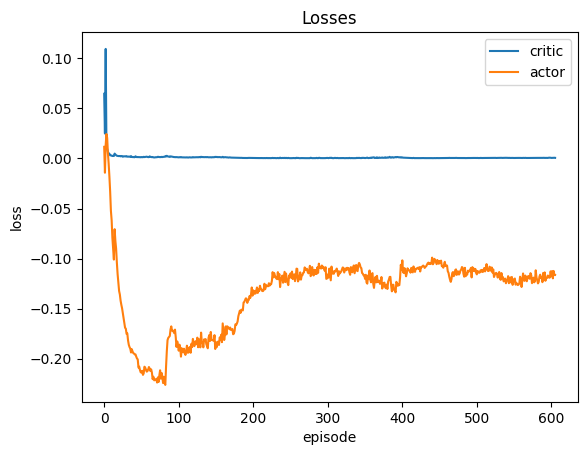

In [31]:
plt.plot(loss_critic, label='critic')
plt.plot(loss_actor, label='actor')
plt.legend()
plt.title('Losses')
plt.xlabel('episode')
plt.ylabel('loss')
plt.show()

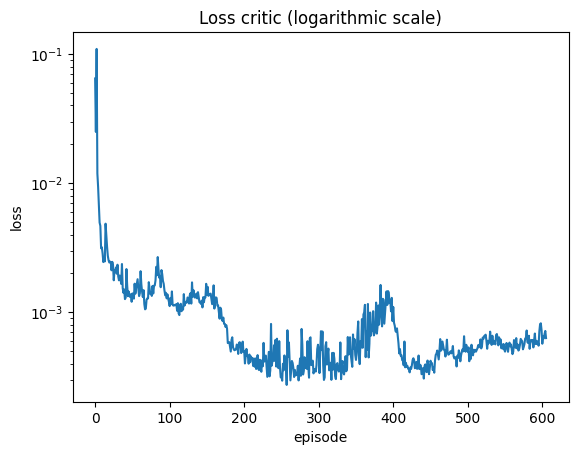

In [32]:
plt.plot(loss_critic, label='critic')
plt.ylabel('loss')
plt.xlabel('episode')
plt.title('Loss critic (logarithmic scale)')
plt.yscale('log')
plt.show()

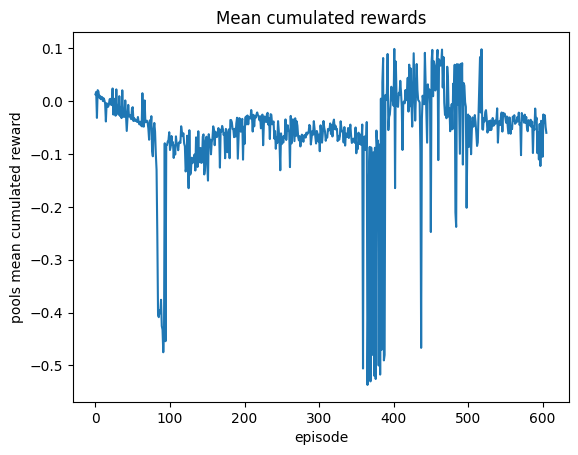

In [33]:
plt.plot(cumulated_rewards)
plt.title('Mean cumulated rewards')
plt.xlabel('episode')
plt.ylabel('pools mean cumulated reward')
plt.show()

In [34]:
agent.save(output_directory / 'models' / f'ddpg_agent_{case}-{datetime.now().strftime("%Y.%m.%d_%H.%M.%S")}.zip')

In [35]:
agent.eval()
pred_states, pred_actions, pred_rewards = simulate_closed_loop_episodes(initial_states, agent, turn_length)

In [36]:
true_actions = np.array(df['pitch'][1:]) - np.array(df['pitch'][:-1])
true_actions = torch.tensor(true_actions, dtype=torch.float32).to(device).reshape(-1, 1)
min(true_actions)

tensor([-0.1327], device='cuda:0')

In [37]:
min(pred_actions), min(true_actions), denormalize_actions(torch.tensor(min_action).to(device))

(tensor([-0.1269], device='cuda:0'),
 tensor([-0.1327], device='cuda:0'),
 tensor([-0.1665], device='cuda:0'))

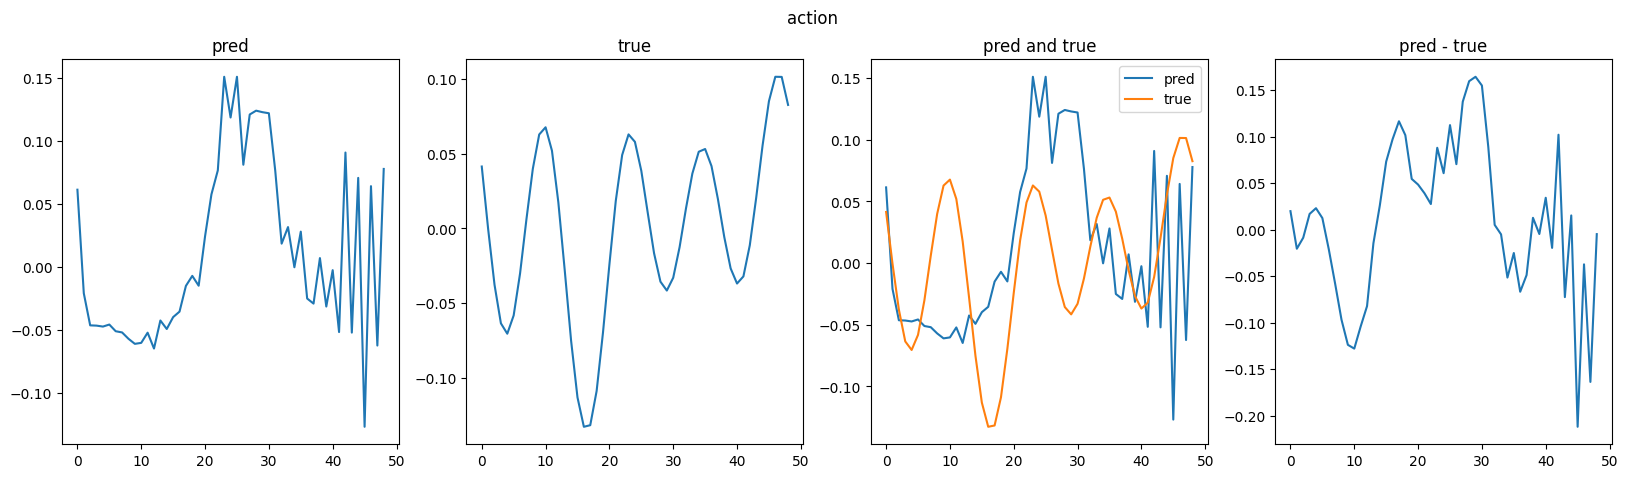

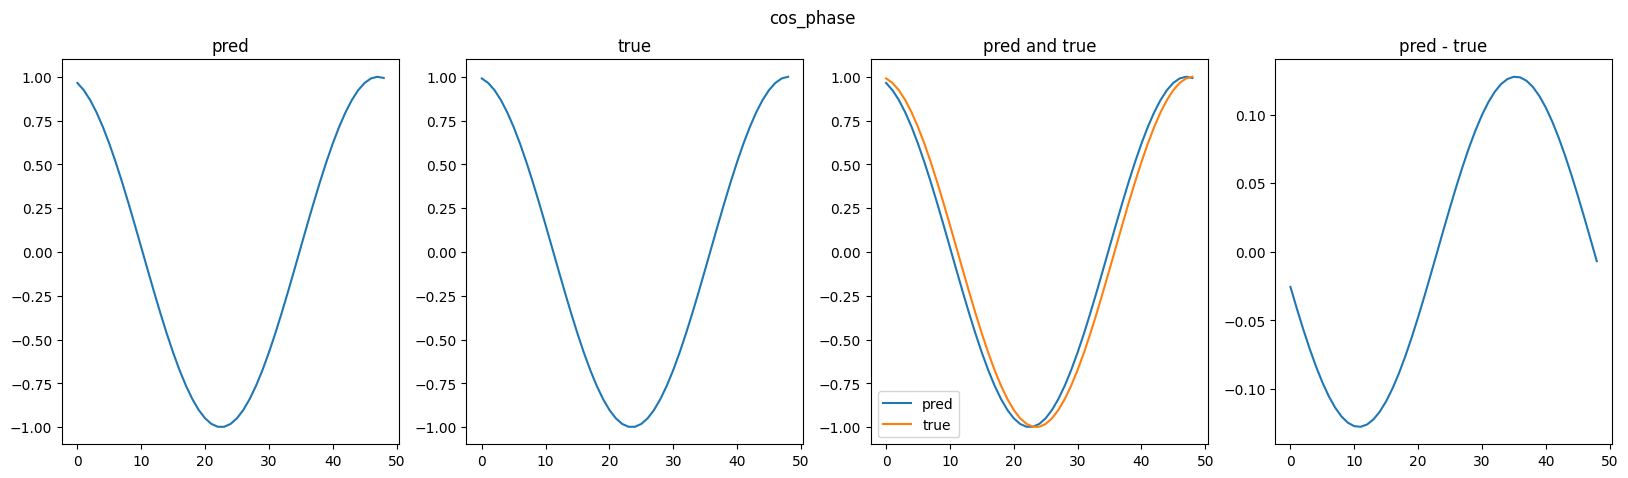

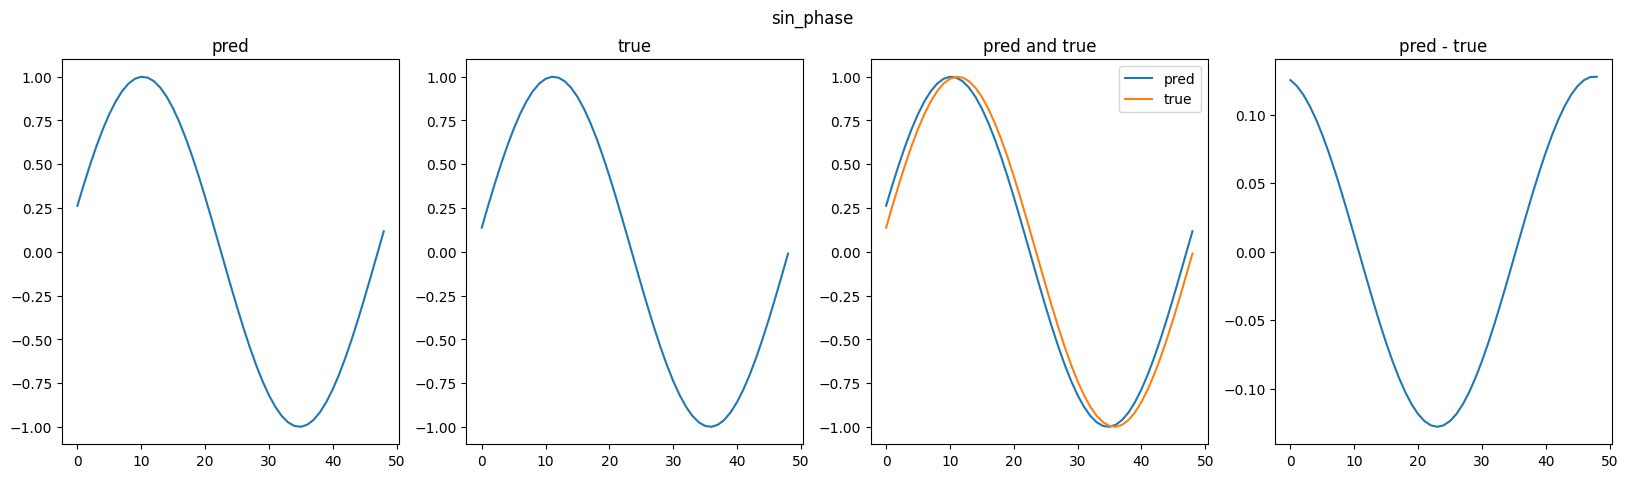

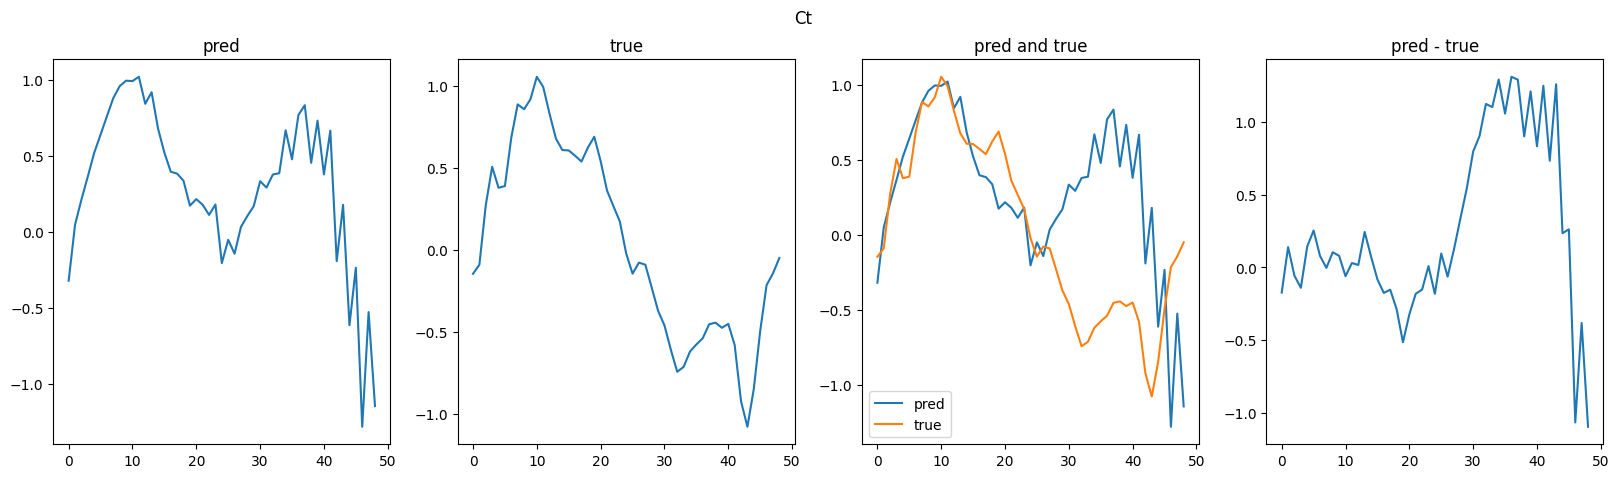

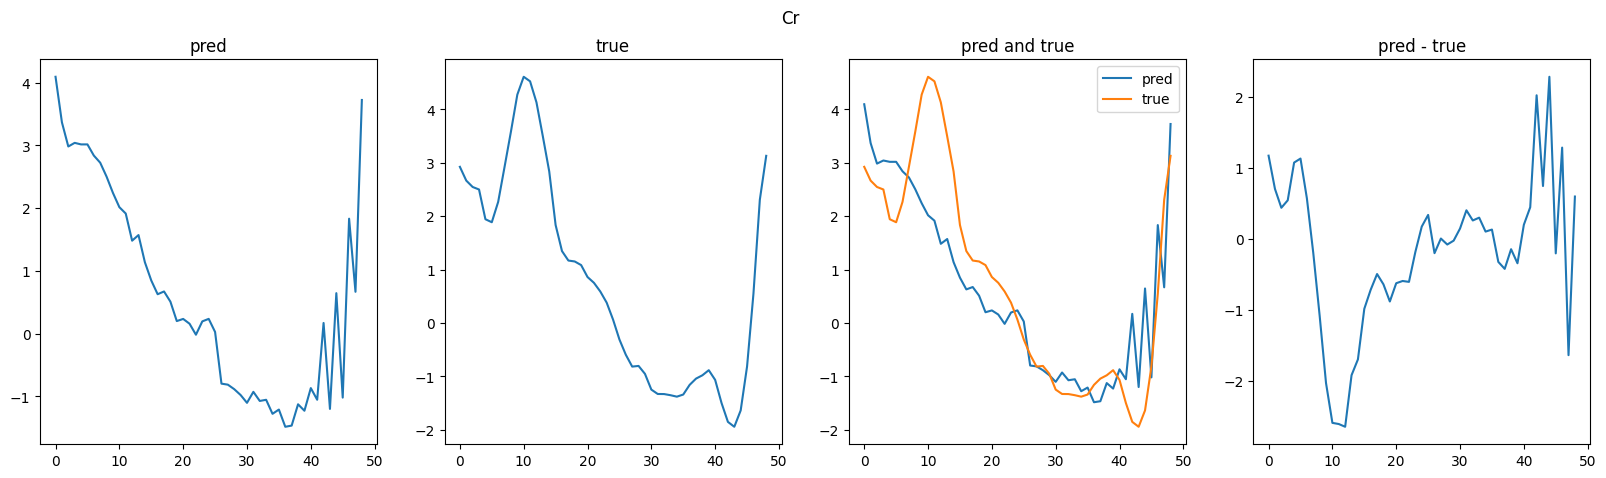

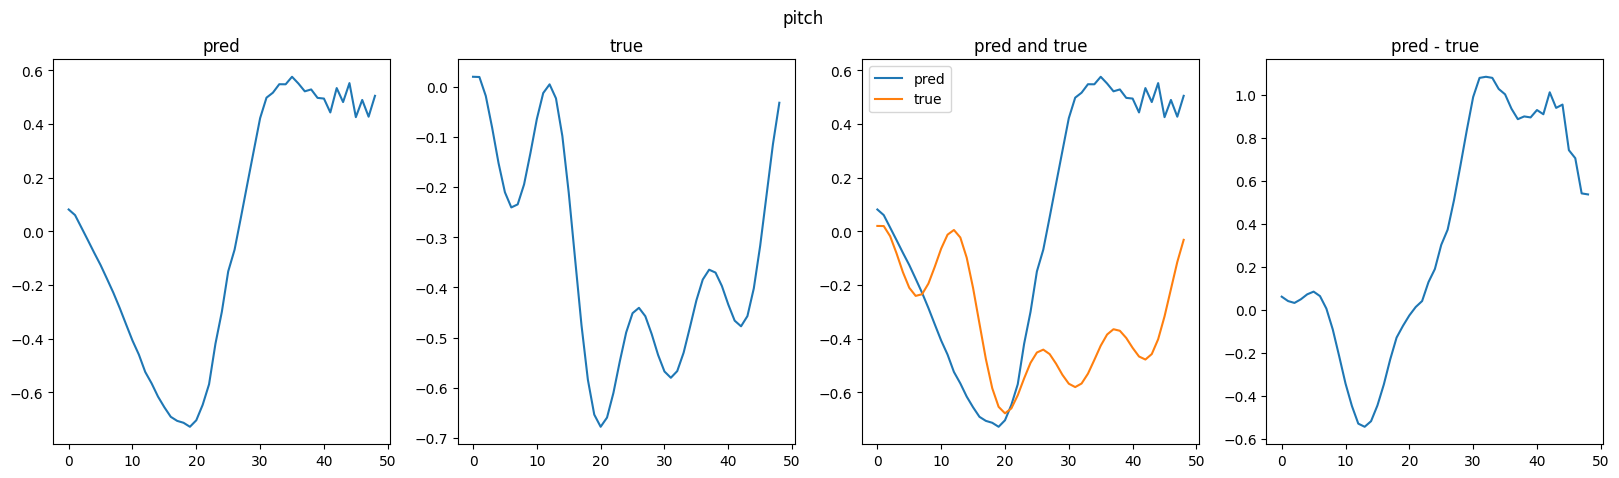

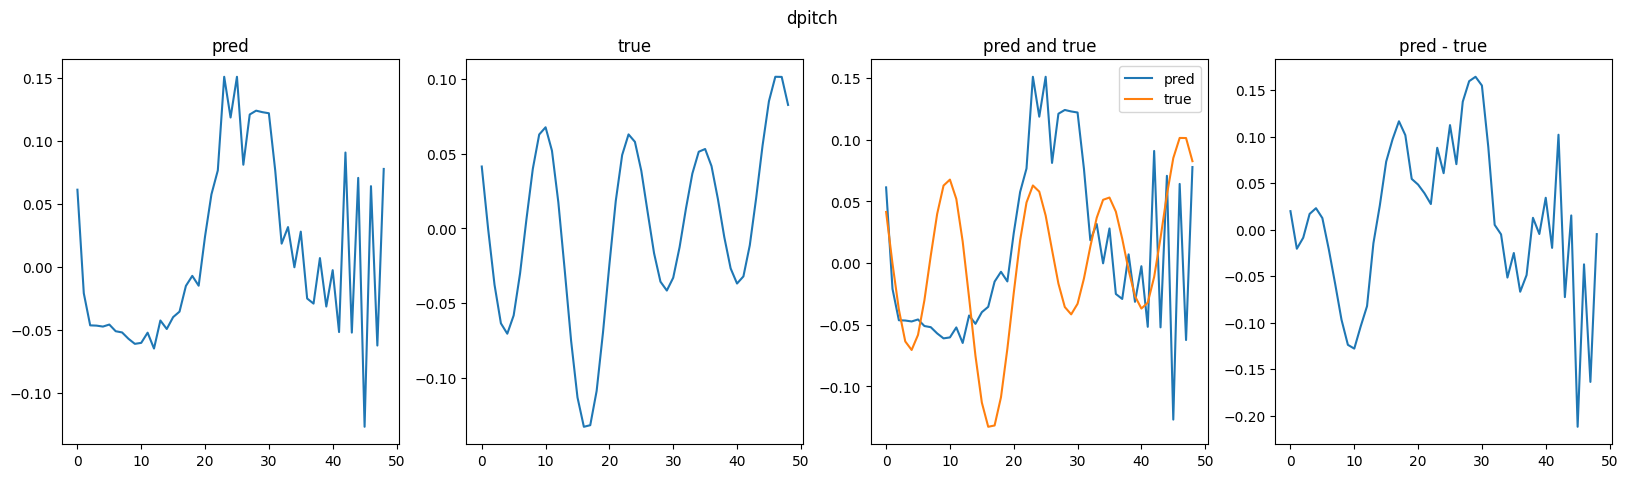

In [38]:
plot_compare_episodes(pred_states, pred_actions, true_states, true_actions, n=49)

In [ ]:
tdataframe = pd.read_pickle(f'outputs/dataset/case 2/dataframes/res/ms006mpt001.pkl')[
             :1000]  # test dataframe
tstates, tactions, trewards, tdone = df2sarsa(tdataframe)
states_means, states_stds = np.array(norm_infos['X mean'][:-1]), np.array(norm_infos['X std'][:-1])
actions_means, actions_stds = np.array(norm_infos['Y mean']), np.array(norm_infos['Y std'])
tstates = (tstates - states_means) / states_stds

In [ ]:
from ipywidgets import interact


@interact(actor=True, critic=True)
def plot_q_values(actor=True, critic=True):
    # plot q-values of every action at every state of the episode on a heatmap
    n_actions, n_states = 100, 100
    all_actions = np.linspace(min_action, max_action, n_actions)
    all_states = tstates[:n_states]
    all_states = np.repeat(all_states, len(all_actions), axis=0)
    all_actions = np.tile(all_actions, len(all_states) // len(all_actions))
    all_actions = all_actions.reshape(-1, 1)
    all_states = torch.Tensor(all_states).to(device)
    all_actions = torch.Tensor(all_actions).to(device)
    all_q_values = agent.critic(torch.cat((all_states, all_actions), dim=1)).detach().to('cpu').numpy()
    all_q_values = all_q_values.reshape(n_states, n_actions)
    plt.imshow(all_q_values.T, aspect='auto')
    # plot over it the best actions
    if critic:
        best_actions = np.argmax(all_q_values, axis=1)
        plt.plot(best_actions, label='argmax', color='r', linewidth=1, linestyle='--')
    # plot over it actions determined by the actor
    if actor:
        # zero rewards for evaluation
        rewards = torch.zeros(n_states).to(device)
        done = torch.zeros(n_states).to(device)
        actor_actions = agent(torch.Tensor(tstates[:n_states]).to(device).T,
                              rewards, done).to('cpu').numpy()
        actor_actions = np.interp(actor_actions, (actor_actions.min(), actor_actions.max()), (0, n_actions))
        plt.plot(actor_actions, label='actor', color='w', linewidth=1, linestyle='--')
    plt.legend()
    plt.colorbar()
    plt.title('Q-values')
    plt.ylabel('action')
    plt.xlabel('state')
    plt.yticks(np.linspace(0, n_actions, 5), [f'{x:.3f}' for x in np.linspace(min_action, max_action, 5)])
    plt.xticks(np.linspace(0, n_states, 5), np.linspace(0, n_states, 5))
    # set fig size
    fig = plt.gcf()
    fig.set_size_inches(15, 2)
    # invert y axis
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
plot_q_values()